### Install packages

In [1]:
# We need xgcm >0.7.0 to get grid ufuncs
!pip install git+https://github.com/xgcm/xgcm.git

  Cloning https://github.com/xgcm/xgcm.git to /tmp/pip-req-build-13t3ppir
  Running command git clone --filter=blob:none --quiet https://github.com/xgcm/xgcm.git /tmp/pip-req-build-13t3ppir
  Resolved https://github.com/xgcm/xgcm.git to commit 81460fb91b12dacce640cc13002270cc48bf98c7
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
  Created wheel for xgcm: filename=xgcm-0.8.1.dev4+g81460fb-py3-none-any.whl size=94758 sha256=ade8301d5ab63405e769a0ad15697a771248b510923f2490599191ff3e1c80a4
  Stored in directory: /tmp/pip-ephem-wheel-cache-_yeyy02p/wheels/26/7a/09/292d90418050fbb90e9ea92a07bb96aec29bfe790cbdd2c396
Successfully built xgcm
  Attempting uninstall: xgcm
    Found existing installation: xgcm 0.7.0
    Uninstalling xgcm-0.7.0:
      Successfully uninstalled xgcm-0.7.0


In [2]:
# We need the xarray PR with `inline_array`
!pip install git+https://github.com/pydata/xarray.git --no-dependencies

  Cloning https://github.com/pydata/xarray.git to /tmp/pip-req-build-h7xws2im
  Running command git clone --filter=blob:none --quiet https://github.com/pydata/xarray.git /tmp/pip-req-build-h7xws2im
  Resolved https://github.com/pydata/xarray.git to commit ae2c3a74f1c2ca7dc41bbf34862b239b7e3c5651
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for xarray: filename=xarray-2022.6.0rc1.dev34+gae2c3a74-py3-none-any.whl size=924740 sha256=35ddfc5047e656b0eb6b5402f637dfcce62ba50b37d1c3a7b16feac0fab7b6be
  Stored in directory: /tmp/pip-ephem-wheel-cache-t_ftpj2a/wheels/98/98/66/2e5174c1595042a0df2d87215df0a100653ecafca657e7a384
Successfully built xarray
  Attempting uninstall: xarray
    Found existing installation: xarray 2022.3.0
    Uninstalling xarray-2022.3.0:
      Successfully uninstalled xarray-2022.3.0


In [3]:
import xarray as xr

In [4]:
xr.__version__

'2022.6.0rc1.dev34+gae2c3a74'

In [5]:
import xgcm

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

### Define calculation

We want to calculate the integral formula for [relative vorticity](https://mitgcm.readthedocs.io/en/latest/algorithm/algorithm.html?highlight=vorticity#relative-vorticity) in terms of circulation around a grid cell:

$$
  \zeta_3 = \frac{\Gamma}{A_\zeta} = \frac{1}{{\cal A}_\zeta} ( \delta_i \Delta y_c v - \delta_j \Delta x_c u )
$$

where $u$ and $v$ are horizontal and vertical components of surface velocity respectively.

In [7]:
def vort_ufunc(u, dxc, v, dyc, raz):
    u_trans = u * dxc
    v_trans = v * dyc
    v_diff_x = v_trans[..., 1:, 1:] - v_trans[..., 1:, :-1]
    u_diff_y = u_trans[..., 1:, 1:] - u_trans[..., :-1, 1:]
    return (v_diff_x - u_diff_y) / raz[..., 1:, 1:]


def vort(ds, grid):
    """Dimensionally-consistent relative vorticity"""

    u = ds.U
    v = ds.V
    dxC = ds.dxC
    dyC = ds.dyC
    rAz = ds.rAz
       
    zeta = grid.apply_as_grid_ufunc(
        vort_ufunc,
        u, dxC, v, dyC, rAz,
        axis= 5 * [("Y", "X")],
        signature="(Y:center,X:left),(Y:center,X:left),(Y:left,X:center),(Y:left,X:center),(Y:left,X:left)->(Y:left,X:left)",
        boundary_width={"X": (1, 0), "Y": (1, 0)},
        boundary={"X": "periodic", "Y": "periodic"},
        dask="forbidden",   # data should have been loaded in already
    )
    
    return zeta

We also want the **strain magnitude**, given by the vector magnitude of the two strain components, normal strain ($\sigma_n$) and shear strain ($\sigma_s$)

$$
\sigma = \sqrt{\sigma_n^2 + \sigma_s^2}
$$

where the components are given in terms of surface velocity components $u$ and $v$ as

$$
\sigma_n = \frac{\partial u}{\partial x} - \frac{\partial v}{\partial y}
$$
$$
\sigma_s = \frac{\partial v}{\partial x} - \frac{\partial u}{\partial y}
$$

In [8]:
def strain_ufunc(u, dxc, v, dyc):
    
    # TODO are these derivatives actually correct??
    u_diff_x = (u[..., 1:] - u[..., :-1]) / dxc[..., 1:]
    v_diff_x = (v[..., 1:] - v[..., :-1]) / dxc[..., 1:]
    u_diff_y = (u[..., 1:, :] - u[..., :-1, :]) / dyc[..., 1:, :]
    v_diff_y = (v[..., 1:, :] - v[..., :-1, :]) / dyc[..., 1:, :]
    
    u_diff_x_trimmed = u_diff_x[..., 1:, :]
    v_diff_x_trimmed = v_diff_x[..., 1:, :]
    u_diff_y_trimmed = u_diff_y[..., 1:]
    v_diff_y_trimmed = v_diff_y[..., 1:]
    
    strain_normal = u_diff_x_trimmed - v_diff_y_trimmed
    strain_shear = v_diff_x_trimmed + u_diff_y_trimmed
    
    strain_mag = np.sqrt(strain_normal ** 2 +  strain_shear ** 2)
    
    return strain_mag
    

def strain(ds, grid):
    """Strain magnitude"""
    
    u = ds.U
    v = ds.V
    dxC = ds.dxC
    dyC = ds.dyC
    
    sigma = grid.apply_as_grid_ufunc(
        strain_ufunc,
        u, dxC, v, dyC,
        axis= 4 * [("Y", "X")],
        signature="(Y:center,X:left),(Y:center,X:left),(Y:left,X:center),(Y:left,X:center)->(Y:left,X:left)",
        boundary_width={"X": (1, 0), "Y": (1, 0)},
        boundary={"X": "periodic", "Y": "periodic"},
        dask="forbidden",   # data should have been loaded in already
    )
    
    return sigma

In [9]:
from xhistogram.xarray import histogram

In [10]:
def coriolis_parameter(ds):
    rotation_rate = 7.2921e-5  # rad/s
    latitude = ds.YG
    
    f = 2 * rotation_rate * np.sin(latitude*np.pi/180)
    
    return f

In [11]:
def hist(omega, sigma, f):
      
    # from Dhruv's notebook
    #vortband01 = np.linspace(-7, 7, 240)
    #strainband01 = np.linspace(.5e-3, 7, 240)
    
    vort_normed = omega / f
    vort_normed.name = "vort / f"
    strain_normed = abs(sigma / f)
    strain_normed.name = "strain / f"
    
    vort_max = 7
    vort_bins = np.linspace(-vort_max, vort_max, 100)
    
    strain_max = 7
    strain_bins = np.linspace(0.0, strain_max, 100)
    
    hist = histogram(
        vort_normed, 
        strain_normed, 
        dim=['i_g', 'j_g'], 
        bins=[vort_bins, strain_bins],
        block_size=None,  # avoids a divide-by-zero bug in xhistogram's code for automatically determining block_size
        density=True,  # we don't care about number of grid points, so plot probability density
        keep_coords=True,
    )
    
    return hist

### Open data

In [12]:
def open_llc4320_velocity_data(chunks="auto"):
    
    ds_SSU = xr.open_dataset(
        "gs://pangeo-ecco-llc4320/ssu", 
        engine="zarr", 
        storage_options={'requester_pays': True}, 
        chunks=chunks, 
        consolidated=True, 
        inline_array=True,
    )
    
    ds_SSV = xr.open_dataset(
        "gs://pangeo-ecco-llc4320/ssv", 
        engine="zarr", 
        storage_options={'requester_pays': True}, 
        chunks=chunks, 
        consolidated=True, 
        inline_array=True,
    )
    
    # Open grid data
    ds_grid = xr.open_dataset(
        "gs://pangeo-ecco-llc4320/grid", 
        engine="zarr", 
        storage_options={'requester_pays': True}, 
        chunks=chunks, 
        consolidated=True, 
        inline_array=True,
    )
    ds_grid = ds_grid.drop(['k_p1','Zp1', 'Zl', 'PHrefF', 'drC', 'k_l', 'k', 'k_u'])
    
    ds = xr.merge([ds_SSU, ds_SSV, ds_grid])
    
    return ds, ds_grid

### Open data and grid

In [13]:
def open_and_load(slices):
    
    # opens all LLC data needed
    ds, ds_grid = open_llc4320_velocity_data()
    
    # remove coordinates we won't use to save memory
    coords_to_keep = ["i", "i_g", "j", "j_g", "XG", "YG", "dxC", "dyC", "rAz", "time"]
    ds = ds.drop_vars(set(ds.coords) - set(coords_to_keep))
    
    # create xGCM grid
    grid = xgcm.Grid(ds_grid[['i', 'i_g', 'j', 'j_g']], periodic=['X'])
    
    # slice data lazily
    subset = ds.isel(slices)
    
    # load in subset of data
    return subset.load(), grid

In [14]:
def vort_strain_hist(slices):
    
    ds, grid = open_and_load(slices)
    
    omega = vort(ds, grid)
    sigma = strain(ds, grid)

    f = coriolis_parameter(ds)
    
    h = hist(omega, sigma, f)
    return h

### test on a subset (in-memory)

In [15]:
subset_slice = {"time": 0}

In [16]:
ds, grid = open_and_load(subset_slice)

In [17]:
omega = vort(ds, grid)
sigma = strain(ds, grid)

In [18]:
ds

<xarray.Dataset>
Dimensions:  (face: 13, j: 4320, i_g: 4320, j_g: 4320, i: 4320)
Coordinates:
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
    time     datetime64[ns] 2011-09-13
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
    XG       (face, j_g, i_g) float32 -115.0 -115.0 -115.0 ... -114.7 -114.9
    YG       (face, j_g, i_g) float32 -88.18 -88.18 -88.18 ... -88.17 -88.17
    dxC      (face, j, i_g) float32 324.6 324.6 324.6 ... 479.3 479.1 479.0
    dyC      (face, j_g, i) float32 239.5 239.5 239.5 ... 324.6 324.6 324.6
    rAz      (face, j_g, i_g) float32 7.774e+04 7.775e+04 ... 1.555e+05
Dimensions without coordinates: face
Data variables:
    U        (face, j, i_g) float32 nan nan nan nan nan ... nan nan nan nan nan
    V        (face, j_g, i) float32 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    Conventions:  CF-1.6
    history:      Created by calling `open_mdsdataset(llc_method='smallchunks...
    source:       MITgcm
    title:        netCDF wrapper of MITgcm MDS binary data

In [19]:
f = coriolis_parameter(ds)

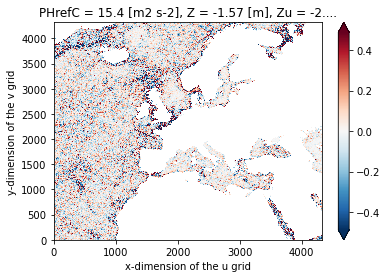

In [20]:
(omega / f).isel(face=2).plot(robust=True)

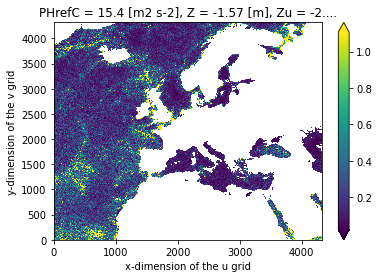

In [21]:
abs(sigma / f).isel(face=2).plot(robust=True)

In [22]:
h = hist(omega, sigma, f)
h

<xarray.DataArray 'histogram_vort / f_strain / f' (face: 13, vort / f_bin: 99,
                                                   strain / f_bin: 99)>
array([[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         2.78688908e-05, 2.09016681e-05, 1.39344454e-05],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         2.78688908e-05, 0.00000000e+00, 3.48361135e-05],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         2.78688908e-05, 1.39344454e-05, 1.39344454e-05],
...
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         3.54897940e-05, 2.12938764e-05, 3.54897940e-05],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         4.25877528e-05, 1.41959176e-05, 2.12938764e-05],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         3.54897940e-05, 3.54897940e-05, 2.83918352e-05]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]])
Coordinates:
  * vort / f_bin    (vort / f_bin) float64 -6.929 -6.788 -6.646 ... 6.788 6.929
  * strain / f_bin  (strain / f_bin) float64 0.03535 0.1061 ... 6.894 6.965
    PHrefC          float32 15.4
    Z               float32 -1.57
    Zu              float32 -2.14
    drF             float32 1.14
    time            datetime64[ns] 2011-09-13
Dimensions without coordinates: face

### Plot resulting histogram

In [23]:
def plot_vort_strain_hist(h):
    
    h = xr.where(h<1e-5, np.nan, h)  # discard values less than threshold
    
    plt.figure(figsize=(10,4.5))
    
    # plot the joint PDF
    h.plot(x="vort / f_bin", vmax = 1e2, norm=mpl.colors.SymLogNorm(1e-4), cmap='Reds')
    
    # plot the lines of perfect correlation / anti-correlation
    strain_max = h.coords["strain / f_bin"].max()
    plt.plot(np.linspace(0, -strain_max, 10),np.linspace(0, strain_max, 10),'k--',alpha=.5)
    vort_max = h.coords["vort / f_bin"].max()
    plt.plot(np.linspace(0, vort_max), np.linspace(0, vort_max),'k--',alpha=.5)
    
    # labels
    plt.xlabel('vorticity/$f_0$')
    plt.ylabel('strain/$|f_0|$')
    
    plt.text(0, strain_max / 2, 'Front')
    plt.text(vort_max / 2, strain_max / 4, 'Cyc')
    plt.text(-vort_max / 2, strain_max / 4, 'Acyc')
    
    # grid
    plt.rc('grid', color='black', alpha=.3)
    plt.grid()

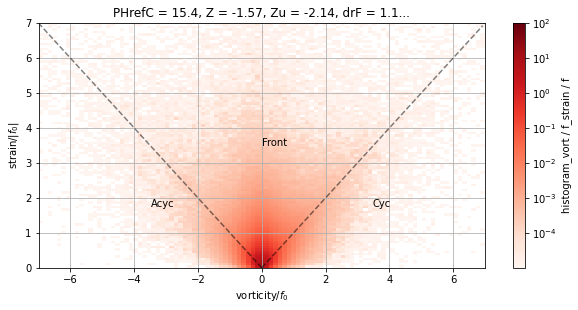

In [24]:
plot_vort_strain_hist(h.isel(face=2))

### Create cluster

In [25]:
import dask

In [26]:
from dask_gateway import Gateway
g = Gateway()

In [47]:
options = g.cluster_options()
options.worker_cores = 1
options.worker_memory = 50

In [48]:
gc = g.new_cluster(cluster_options=options)

### install packages on workers

In [49]:
from dask.distributed import PipInstall

In [50]:
client = gc.get_client()
plugin = PipInstall(packages=["git+https://github.com/xgcm/xgcm.git", "git+https://github.com/pydata/xarray.git --no-dependencies"])
client.register_worker_plugin(plugin)

{}

In [51]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.cc277dc35b0048388938dde96b70b491/status,


### scale cluster

In [52]:
gc.scale(20)

In [53]:
gc.dashboard_link

'/services/dask-gateway/clusters/prod.cc277dc35b0048388938dde96b70b491/status'

In [54]:
gc

### Map over whole dataset

In [55]:
def compute_hist(ds, grid):
    """Expects a single in-memory chunk of a dataset"""
    
    omega = vort(ds, grid)
    sigma = strain(ds, grid)

    f = coriolis_parameter(ds)
    
    h = hist(omega, sigma, f)
    
    h = h.assign_coords({"time": ds.coords['time']})  # ensure this doesn't get lost - needed for reconstruction
    h = h.drop_vars(['PHrefC', 'drF', 'Z', 'Zu'], errors='ignore')
    
    return h

In [56]:
# open all data, chunked along time and face
ds, ds_grid = open_llc4320_velocity_data(chunks="auto")

# remove coordinates we won't use to save memory
coords_to_keep = ["i", "i_g", "j", "j_g", "XG", "YG", "dxC", "dyC", "rAz", "time"]
ds = ds.drop_vars(set(ds.coords) - set(coords_to_keep))

# create xGCM grid
grid = xgcm.Grid(ds_grid[['i', 'i_g', 'j', 'j_g']], periodic=['X'])

In [57]:
ds

<xarray.Dataset>
Dimensions:  (time: 9030, face: 13, j: 4320, i_g: 4320, j_g: 4320, i: 4320)
Coordinates:
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-09-23T05:00:00
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
    XG       (face, j_g, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    YG       (face, j_g, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    dxC      (face, j, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    dyC      (face, j_g, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    rAz      (face, j_g, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
Dimensions without coordinates: face
Data variables:
    U        (time, face, j, i_g) float32 dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>
    V        (time, face, j_g, i) float32 dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      Created by calling `open_mdsdataset(llc_method='smallchunks...
    source:       MITgcm
    title:        netCDF wrapper of MITgcm MDS binary data

In [58]:
ds.nbytes / 1e12

17.53108552248

In [39]:
hist_template = xr.DataArray(
    name="histogram_vort / f_strain / f", 
    dims=['face', 'vort / f_bin', 'strain / f_bin', 'time'],
    data=np.random.randn(13, 99, 99, 9030),
    coords={'vort / f_bin': h.coords['vort / f_bin'], 
            'strain / f_bin': h.coords['strain / f_bin'], 
            'time': ds.coords['time']}
).chunk({"face": 1, "time": 1})

hist_template

,Array,Chunk
Bytes,8.57 GiB,76.57 kiB
Shape,"(13, 99, 99, 9030)","(1, 99, 99, 1)"
Count,117390 Tasks,117390 Chunks
Type,float64,numpy.ndarray


In [45]:
compute_hist(ds.isel(time=0).load(), grid)

<xarray.DataArray 'histogram_vort / f_strain / f' (face: 13, vort / f_bin: 99,
                                                   strain / f_bin: 99)>
array([[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         2.78688908e-05, 2.09016681e-05, 1.39344454e-05],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         2.78688908e-05, 0.00000000e+00, 3.48361135e-05],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         2.78688908e-05, 1.39344454e-05, 1.39344454e-05],
...
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         3.54897940e-05, 2.12938764e-05, 3.54897940e-05],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         4.25877528e-05, 1.41959176e-05, 2.12938764e-05],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         3.54897940e-05, 3.54897940e-05, 2.83918352e-05]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]])
Coordinates:
  * vort / f_bin    (vort / f_bin) float64 -6.929 -6.788 -6.646 ... 6.788 6.929
  * strain / f_bin  (strain / f_bin) float64 0.03535 0.1061 ... 6.894 6.965
    time            datetime64[ns] 2011-09-13
Dimensions without coordinates: face

In [59]:
# map histogram calculation over all data
full_h = ds.isel(time=slice(0, 2)).map_blocks(compute_hist, [grid], template=hist_template.isel(time=slice(0, 2)))

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.53933 to fit


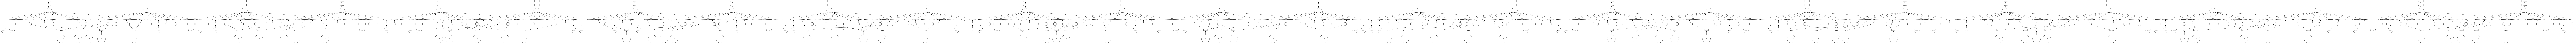

In [62]:
full_h.data.visualize(optimize_graph=True)

In [60]:
full_h.nbytes / 1e9

0.002038608

In [61]:
full_h.compute()


KeyboardInterrupt



In [ ]:
plot_vort_strain_hist(full_h.isel(face=2).mean(dim="time"))

In [63]:
gc.close()

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask_gateway/client.py:1014: RuntimeWarning: coroutine 'rpc.close_rpc' was never awaited
  self.scheduler_comm.close_rpc()


In [64]:
client.close()